In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
nfile = 'data/phishing_final.xlsx'
DATA_PATH= 'data/'

In [2]:
emailpool = pd.read_excel(nfile,sheet_name = 'emailpool')
spear_phishing = pd.read_excel(nfile,sheet_name='spear_phishing')
userclassification = pd.read_excel(nfile,sheet_name='userclassification')
rater = pd.read_csv(DATA_PATH+'rater.compiled.csv')
raterids = rater['UserID'].tolist()
spear_phishing = spear_phishing[spear_phishing['TargetID'].isin(rater['UserID'])]

In [3]:
userclassification = userclassification[userclassification['RaterID'].isin(rater['UserID'])]
emailpool['spearIndicator'] = [0 for _ in range(len(emailpool))]
spear_phishing['spearIndicator'] = [1 for _ in range(len(spear_phishing))]
con_emails = pd.concat([emailpool[['Email','Subject','spearIndicator','ID']].rename(columns = {'ID':'PhishID'}),
                        spear_phishing[['EmailCont','Subject','spearIndicator','id']].rename(columns ={'EmailCont':'Email','id':'PhishID'})])
con_emails = con_emails.reset_index()

In [4]:
con_emails['index'] = con_emails.index
userclassification = pd.merge(con_emails[['index','spearIndicator','PhishID']],userclassification,on = ['PhishID','spearIndicator'], how = 'right')

In [8]:
emailpool['Type'].value_counts()

1    210
2     52
0     15
Name: Type, dtype: int64

In [6]:
spear_phishing.shape

(252, 40)

In [12]:
print('number of classification: ',len(userclassification))
print('number of end-users: ',len(userclassification['RaterID'].unique()))
print('average emails classifed per user:', round(len(userclassification)/len(userclassification['RaterID'].unique()),2))
print('Number of spear phishing email:',spear_phishing.shape[0])
print('Number of mass phishing: ',emailpool['Type'].value_counts()[0])
print('Number of ham email: ',emailpool['Type'].value_counts()[1])
print('Number of promotion email: ',emailpool['Type'].value_counts()[2])

number of classification:  6712
number of end-users:  84
average emails classifed per user: 79.9
Number of spear phishing email: 252
Number of mass phishing:  15
Number of ham email:  210
Number of promotion email:  52


In [8]:
surveyfields = ['important', 'action', 'information', 'project',
       'meeting', 'spam', 'deadline', 'other']
summarydf = userclassification.groupby(['spearIndicator','PhishID'],as_index= False)[surveyfields].mean()#.loc[0,3]

In [9]:
con_emails =pd.merge(con_emails,summarydf,on = ['spearIndicator','PhishID'])#.dropna()

In [10]:
def getresponse(Response):
    if Response>=3:
        return 'Ignore'
    else:
        return 'Response'
userclassification['Response_'] = userclassification['Response'].apply(getresponse)


In [11]:
emailpool.keys()

Index(['ID', 'Attachment', 'Email', 'Subject', 'Type', 'User',
       'spearIndicator'],
      dtype='object')

In [12]:
spear_phishing.keys()

Index(['id', 'UserID', 'Trial', 'Cost', 'Goal', 'Templete', 'Capital',
       'Subject', 'EmailCont', 'SubjectEdit', 'BodyEdit', 'KeyStroke',
       'NumEdit', 'Practice_I', 'Status', 'ProfileTS', 'AttackStartTS',
       'AttackFinishTS', 'LoadTS', 'SubmitTS', 'Impersonation', 'Offer',
       'Followup', 'Threaten', 'Failure', 'Authority', 'Peers', 'Time',
       'Pretend', 'Interest', 'Other', 'Self_eval', 'User_info', 'TargetID',
       'Tone', 'Personal_', 'Professional_', 'Family_', 'Interest_',
       'spearIndicator'],
      dtype='object')

In [13]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
add_stop_words = ['nbsp','n','p','r',';','&']
stop_words.extend(add_stop_words)

def preprocess_text(sentence,punctuation = True):
    # Removing html tags
    sentence = remove_tags(sentence)
#    sentence = process_NER(sentence)
    # Remove punctuations and numbers
    if punctuation:
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('nbsp',' ',sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    tokens = wpt.tokenize(sentence)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    sentence = ' '.join(filtered_tokens)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
def trim_string(x,first_n_words):
    x = x.split(maxsplit=first_n_words)
    return ' '.join(x[:first_n_words]).replace('\n', '').replace('\r', '')

In [14]:
emailpool.keys()

Index(['ID', 'Attachment', 'Email', 'Subject', 'Type', 'User',
       'spearIndicator'],
      dtype='object')

In [15]:
con_emails['cleantext'] = (con_emails['Subject'].astype('str')+' '+con_emails['Email'].astype('str')).apply(preprocess_text)
con_emails['cleantext_withpunc'] = (con_emails['Subject'].astype('str')+' '+con_emails['Email'].astype('str')).apply(preprocess_text,punctuation=False)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
documents = con_emails['cleantext'] 
#Raw documents to tf-idf matrix (or normal count could be done too) 
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)
#SVD for dimensionality reduction
svd_model = TruncatedSVD(n_components=300,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
#Pipe tf-idf and SVD, apply on our input documents
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(documents)

In [17]:
import spacy
nlp = spacy.load('en_vectors_web_lg')
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


In [18]:
unique_words = list(set([word for sublist in [doc.split() for doc in con_emails['cleantext']] for word in sublist]))
unique_words.sort()
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

In [19]:
word_glove_vectors.shape

(6213, 300)

In [20]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',vocabulary = unique_words)
count_vect.fit(con_emails['cleantext'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(con_emails['cleantext'])
wordlist = count_vect.get_feature_names()


X = xtrain_count.todense()
glove_vector = np.dot(np.array(X),np.array(word_glove_vectors))


In [21]:
con_emails['important'] = (con_emails['important']-1)/8
import sklearn

simmatrix_svd = sklearn.metrics.pairwise.cosine_similarity(svd_matrix,svd_matrix) 
simmatrix_glove = sklearn.metrics.pairwise.cosine_similarity(glove_vector,glove_vector) 

average_surveymatrix = con_emails[surveyfields].fillna(1).values
simmatrix_averageSurvey = sklearn.metrics.pairwise.cosine_similarity(average_surveymatrix,average_surveymatrix) 

surveymatrix = userclassification[surveyfields].fillna(1).values
simmatirx_survey = sklearn.metrics.pairwise.cosine_similarity(surveymatrix,surveymatrix) 

In [22]:
simmatrix_svd.shape

(529, 529)

In [23]:
simmatirx_survey.shape

(6712, 6712)

In [43]:
import pickle
output = open('./data/glovematrix.pkl', 'wb')
pickle.dump(simmatrix_glove, output)
output.close()
simmatirx_survey.shape

(6712, 6712)

In [24]:
nmax = 0.20827

np.where(np.abs(diffmatrix[:30,:30]-nmax)<0.0001)

NameError: name 'diffmatrix' is not defined

In [ ]:
np.sort(diffmatrix[:14,:14])[:,-1]

In [65]:
a,b = 2,12
simmatrix_glove[a,b],simmatrix_averageSurvey[a,b]

(0.8777176739808868, 0.7285203942671994)

In [66]:
from IPython.core.display import display, HTML


diffmatrix = simmatrix_glove-simmatrix_averageSurvey
display(HTML(con_emails['Email'][a]))
print('-'*40)
display(HTML(con_emails['Email'][b]))

simmatrix_glove[a,b],simmatrix_averageSurvey[a,b],BERT_Sim(emailcorpus[a],emailcorpus[b],model_semantic)

----------------------------------------


(0.8777176739808868, 0.7285203942671994, 0.337160587310791)

In [28]:
summarydf.loc[a]

spearIndicator    0.000000
PhishID           2.000000
important         5.445319
action            0.829787
information       0.170213
project           0.148936
meeting           0.042553
spam              0.382979
deadline          0.021277
other             0.063830
Name: 2, dtype: float64

In [29]:
summarydf.loc[b]

spearIndicator     0.000000
PhishID           12.000000
important          4.579783
action             0.304348
information        0.739130
project            0.152174
meeting            0.086957
spam               0.565217
deadline           0.065217
other              0.021739
Name: 12, dtype: float64

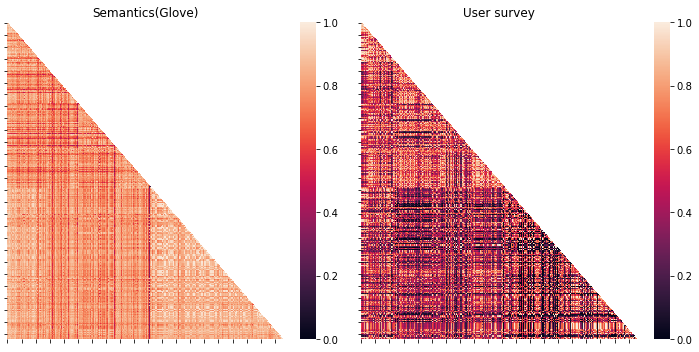

In [31]:
import seaborn as sns;# sns.set_theme()
mask = np.zeros_like(simmatrix_glove)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax = sns.heatmap(simmatrix_glove,mask = mask, vmin=0, vmax=1)
ax.set(xticklabels=[],yticklabels=[],title ='Semantics(Glove)')
plt.subplot(1,2,2)
ax = sns.heatmap(simmatrix_averageSurvey,mask = mask, vmin=0, vmax=1)
ax.set(xticklabels=[],yticklabels=[],title ='User survey')
plt.tight_layout()
plt.savefig('Sim.png')

In [33]:
import scipy.stats
x = simmatrix_glove.flatten()
y = simmatrix_averageSurvey.flatten()
scipy.stats.pearsonr(x,y)

(0.10589761588202941, 0.0)

In [34]:
def cosinedistance(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))
#def cosinedistance(a,b):
#    return simmatrix_glove[a,b]

In [35]:
#cosinedistance(1,3)

In [36]:
surveymatrix.shape

(6712, 8)

In [37]:
# Agent

In [1]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
#model = SentenceTransformer('stsb-roberta-large')
model_save_path = 'data/model/'
model = SentenceTransformer(model_save_path)
model_semantic = SentenceTransformer('nli-distilroberta-base-v2')

In [2]:
sentence1 = "I like Python because I can build AI applications"
sentence2 = "I like Python because I can do data analytics"
# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: I like Python because I can build AI applications
Sentence 2: I like Python because I can do data analytics
Similarity score: 0.9281961917877197


In [4]:
embedding1.shape

torch.Size([768])

In [40]:
def BERT_Sim(sentence1,sentence2,model):
    embedding1 = model.encode(sentence1, convert_to_tensor=True)
    embedding2 = model.encode(sentence2, convert_to_tensor=True)
    # compute similarity scores of two embeddings
    cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
    return cosine_scores.item()


In [ ]:
con_emails.to_csv('data/emails_survey_combined.csv',index = False)

In [41]:
userclassification['important'] = (userclassification['important']-1)/8
emailcorpus = con_emails['cleantext'].tolist()
emailcorpuspunc = con_emails['cleantext_withpunc'].tolist()
userresponse = userclassification[['important', 'action', 'information', 'project',
       'meeting', 'spam', 'deadline', 'other']].values

#userresponse = normalize(userresponse)

In [42]:
con_emails['index']

0        0
1        1
2        2
3        3
4        4
      ... 
524    524
525    525
526    526
527    527
528    528
Name: index, Length: 529, dtype: int64

In [43]:
len(emailcorpus)

529

In [44]:
auser = userclassification[userclassification['RaterID']==raterids[0]].sort_values('Starttime')

In [45]:
np.random.seed(5)
#auser.sample(frac = 1)['index']
np.random.randint(1,100,5)

array([79, 62, 17, 74,  9])

In [61]:
from pyibl import Agent, similarity
from random import random
import math


In [48]:
#Glove
a = 22
b = 29
print('-'*40)
print(emailcorpus[a])
print('-'*40)
print(emailcorpus[b])


----------------------------------------
Your USPS Change Address Confirmation table width height px tr td border px solid black padding px table th text align center button background color border none color white padding px px text align center text decoration none display inline block font size px margin px px cursor pointer Hi Thanks submitting Change Address signing Informed Delivery You receive email Informed Delivery USPS regarding next steps complete signup process Your Change Address Order Submitted August Start Forwarding Date August Confirmation Code View orderMail arrive new address postal business days yourmove effective date OR file date whichever date later Please look Official USPS Change Address Welcome Kit new address soon You able verify Change Address information get valuable savings help move
----------------------------------------
Spice Up Your Valentine Day Plans At Escape The Room Add An Escape To Date Night This Year Dig Escape The RoomEnhance The Valentine Da

In [49]:
#[email index, response ]
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
def negate(r):
    if r =='Response':
        return 'Ignore'
    else:
        return 'Response'

def getPerformance(a,b):
    return [accuracy_score(a,b),precision_score(a,b,pos_label ='Response'),recall_score(a,b,pos_label='Response')]

In [50]:
counts = pd.DataFrame(userclassification.groupby('RaterID')['index'].count())

In [ ]:
a = Agent("Pet Purchaser", ["species", "state"])
a.populate(0, ["parrot", "dead"])
a.populate(10, ["parrot", "squawking"])
a.choose(["parrot", "dead"], ["parrot", "squawking"])

In [51]:
%%time
import random
from tqdm import tqdm
train_rep = 1000
penalties = [1,5,30]#,50,90] 
#penalties = [90]

accruacy=[]
labels = ['Accuracy','Percision','Recall']
similar = {}
## IBL Agent
def train_agent(userid,seeds,Simfunction,randonmization = True,survey = False, train_ratio=0.8,train_rep = 1):
    auser = userclassification[userclassification['RaterID']==userid]#.sort_values('Starttime')
    subaccruacy = {'UserID':userid}
    for penalty in penalties:
        performance = []
        for seed in seeds:
            groundtruth,predicted = [],[]
            #randomize the order
            if randonmization:
                np.random.seed(seed)
                auser = auser.sample(frac = 1)
                #np.random.seed(None)
            agent = Agent(userid, ['email','decison'])
            similarity(Simfunction,"email")
            agent.mismatch_penalty = penalty
            #survey need to comment in 
            if survey:
                #use the survey response or unique emails; Reset index would l
                auser['index'] =auser.index
            array = auser[['index','Response_']].values            
            train,valid = array[:int(train_ratio*len(array))],array[int(len(array)*train_ratio):]
            
            for _ in range(train_rep):
#                random.shuffle(train)
                for x in train:
                    #print(x)
                    agent.populate(1, list(x))
                    agent.populate(-1, [x[0],negate(x[1])])                    
            for x in valid:
                choise = agent.choose(list(x),[x[0],negate(x[1])])
                groundtruth.append(x[1])
                predicted.append(choise[1])
                #print(choise,x)
                agent.respond(0)
            performance.append(getPerformance(groundtruth,predicted))
        performance = np.mean(np.array(performance),axis =0)
        performance_var = np.var(np.array(performance),axis =0)
        for i in range(len(labels)):
            subaccruacy[str(penalty)+'_'+labels[i]] = performance[i]
        for i in range(len(labels)): 
            subaccruacy[str(penalty)+'_var_'+labels[i]] = performance[i]/len(seeds)
    #array.append(subaccruacy)
    return subaccruacy

Wall time: 0 ns


In [52]:
## 1. Add random seed 
## 2. increase rep 
## 3. Randomize the order of the 1000 trial; 
## 4. IBL model; 

In [76]:
import pickle
similarsurvey = {}
similar = {}

similar = pickle.load(open('./data/similar_semantics.pkl','rb'))
similarsurvey = pickle.load(open('./data/similar_survey.pkl','rb'))
def getDocSimLSA(a,b):
    return simmatrix_svd[a,b]

def getDocSimGlove(a,b):

    return simmatrix_glove[a,b]

def getDocSimSurvey(a,b):
    return simmatirx_survey[a,b]

def getDocSimBertSurvey(a,b):
    #
    key = str(a)+'_'+str(b)
    if key not in similarsurvey:
        sim = BERT_Sim(emailcorpus[a],emailcorpus[b],model)
        similarsurvey[key] = sim
    return similarsurvey[key]

def getDocSimBert(a,b):
    #
    key = str(a)+'_'+str(b)
    if key not in similar:
        sim = BERT_Sim(emailcorpus[a],emailcorpus[b],model_semantic)
        similar[key] = sim
    return similar[key]

In [83]:


np.random.seed(8)
train_ratios = [0.5,0.8]
rep = 100
seeds = np.random.randint(1,100,rep)

simmethods = {#'LSA':getDocSimLSA,
             #'Glove':getDocSimGlove,
             'Survey':getDocSimSurvey,
             'Survey_bert':getDocSimBertSurvey,
             'Semantic_Bert':getDocSimBert}


In [84]:
train_ratios = [0.5,0.8]
train_ratio = 0.8
rep = 10
seeds = np.random.randint(1,10000,rep)
print(key,' ',train_ratio)
accuracy = []
for idx in tqdm(range(len(raterids))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimSurvey,train_ratio=train_ratio,survey=True))
accdf = pd.DataFrame(accuracy)
accdf.mean()

  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey_bert   0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:14<00:00,  1.13it/s]


1_Accuracy          0.617814
1_Percision         0.453417
1_Recall            0.432788
1_var_Accuracy      0.061781
1_var_Percision     0.045342
1_var_Recall        0.043279
5_Accuracy          0.699322
5_Percision         0.584806
5_Recall            0.684288
5_var_Accuracy      0.069932
5_var_Percision     0.058481
5_var_Recall        0.068429
30_Accuracy         0.795730
30_Percision        0.715004
30_Recall           0.815267
30_var_Accuracy     0.079573
30_var_Percision    0.071500
30_var_Recall       0.081527
dtype: float64

In [79]:
train_ratios = [0.5,0.8]
rep = 800
seeds = np.random.randint(1,10000,rep)
for key,simmethod in simmethods.items():
    for train_ratio in train_ratios:
        print(key,' ',train_ratio)
        accuracy = []
        for idx in tqdm(range(len(raterids))):
            userid = raterids[idx]
            accuracy.append(train_agent(userid,seeds,simmethod,train_ratio=train_ratio,survey=key=='Survey'))
        accdf = pd.DataFrame(accuracy)
        accdf.to_csv('Result.valid_800/'+key+str(train_ratio)+'.csv',index = False)

  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey   0.8


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey_bert   0.5


 10%|███████▉                                                                           | 8/84 [00:06<01:02,  1.22it/s]


KeyboardInterrupt: 

In [224]:
for key,simmethod in simmethods.items():
    for train_ratio in train_ratios:
        print(key,' ',train_ratio)
        accuracy = []
        for idx in tqdm(range(len(raterids))):
            userid = raterids[idx]
            accuracy.append(train_agent(userid,seeds,simmethod,train_ratio=train_ratio,survey=key=='Survey'))
        accdf = pd.DataFrame(accuracy)
        accdf.to_csv('Result.valid/'+key+str(train_ratio)+'.csv',index = False)

  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

LSA   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]C:\Users\xthbo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


LSA   0.8


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Glove   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Glove   0.8


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey   0.8


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey_bert   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Survey_bert   0.8


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Semantic_Bert   0.5


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Semantic_Bert   0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [11:14<00:00,  8.03s/it]


In [225]:
import pickle
output = open('./data/similar_semantics.pkl', 'wb')
pickle.dump(similar, output)
output.close()

output = open('./data/similar_survey.pkl', 'wb')
pickle.dump(similarsurvey, output)
output.close()


In [93]:
t.ppf(1-0.025,1000)

1.9623390808264074

In [74]:
from scipy.stats import t
sample_var = 0.006
n0 = 100
#h0 = t.ppf(1-0.025,n0)
h0 = 1.95*(sample_var)**0.5
h = 0.06
n = h0**2/h**2*n0
print(h0)
n

0.15104635050208925


633.75

In [99]:
train_ratio = 0.5
rep = 10000
seeds = np.random.randint(1,100000000,rep)
accuracy = []
for idx in tqdm(range(len(raterids[:1]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:21<00:00, 321.65s/it]


,UserID,1_Accuracy,1_Percision,1_Recall,1_var_Accuracy,1_var_Percision,1_var_Recall,5_Accuracy,5_Percision,5_Recall,5_var_Accuracy,5_var_Percision,5_var_Recall,30_Accuracy,30_Percision,30_Recall,30_var_Accuracy,30_var_Percision,30_var_Recall
0,32efff21538c13dd3f8d679dfb66fda0,0.516039,0.385401,0.311358,0.000052,0.000039,0.000031,0.5171,0.394777,0.354129,0.000052,0.000039,0.000035,0.502911,0.353233,0.304132,0.00005,0.000035,0.00003


In [87]:
accdf.mean()

1_Accuracy          0.586938
1_Percision         0.338158
1_Recall            0.256618
1_var_Accuracy      0.586938
1_var_Percision     0.338158
1_var_Recall        0.256618
5_Accuracy          0.593011
5_Percision         0.379759
5_Recall            0.293815
5_var_Accuracy      0.593011
5_var_Percision     0.379759
5_var_Recall        0.293815
30_Accuracy         0.595959
30_Percision        0.424935
30_Recall           0.430415
30_var_Accuracy     0.595959
30_var_Percision    0.424935
30_var_Recall       0.430415
dtype: float64

In [88]:
train_ratio = 0.5
accuracy = []
rep = 10
seeds = np.random.randint(1,100,rep)
for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1_Accuracy          0.583051
1_Percision         0.334984
1_Recall            0.268249
1_var_Accuracy      0.583051
1_var_Percision     0.334984
1_var_Recall        0.268249
5_Accuracy          0.604527
5_Percision         0.389113
5_Recall            0.313263
5_var_Accuracy      0.604527
5_var_Percision     0.389113
5_var_Recall        0.313263
30_Accuracy         0.587249
30_Percision        0.411156
30_Recall           0.402591
30_var_Accuracy     0.587249
30_var_Percision    0.411156
30_var_Recall       0.402591
dtype: float64

In [203]:
train_ratio = 0.5
accuracy = []
rep = 1000
seeds = np.random.randint(1,10000,rep)
for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:57<00:00, 77.74s/it]


,UserID,1_Accuracy,1_Percision,1_Recall,1_var_Accuracy,1_var_Percision,1_var_Recall,5_Accuracy,5_Percision,5_Recall,5_var_Accuracy,5_var_Percision,5_var_Recall,30_Accuracy,30_Percision,30_Recall,30_var_Accuracy,30_var_Percision,30_var_Recall
0,32efff21538c13dd3f8d679dfb66fda0,0.517278,0.378383,0.305294,0.000517,0.000378,0.000305,0.520611,0.400528,0.347499,0.000521,0.000401,0.000347,0.500944,0.360275,0.304098,0.000501,0.000360,0.000304
1,68eff82422ee0ce341e2b8b635bad447,0.583386,0.380751,0.177956,0.000583,0.000381,0.000178,0.600545,0.454686,0.251093,0.000601,0.000455,0.000251,0.604045,0.474892,0.478934,0.000604,0.000475,0.000479
2,e154f85dba016fc4d1d07c62061c87a0,0.677864,0.208073,0.083999,0.000678,0.000208,0.000084,0.694864,0.252267,0.111049,0.000695,0.000252,0.000111,0.689773,0.410963,0.237810,0.000690,0.000411,0.000238
3,2b28aec060b0c3e64e9237c1d757388f,0.705970,0.177802,0.058124,0.000706,0.000178,0.000058,0.689697,0.260467,0.127922,0.000690,0.000260,0.000128,0.647758,0.370749,0.444437,0.000648,0.000371,0.000444
4,531b3014dafd0c2318b9d96e3a70290e,0.481846,0.488226,0.547679,0.000482,0.000488,0.000548,0.491615,0.497973,0.679572,0.000492,0.000498,0.000680,0.514692,0.506737,0.707147,0.000515,0.000507,0.000707
5,7a9e974b437f3b16cbcd7798d92f2b2b,0.733622,0.184402,0.042439,0.000734,0.000184,0.000042,0.726467,0.217272,0.062411,0.000726,0.000217,0.000062,0.661556,0.233040,0.160822,0.000662,0.000233,0.000161
6,269139e2ecc370ba50e750fe0b92fd26,0.478500,0.458125,0.402055,0.000479,0.000458,0.000402,0.476846,0.459025,0.423624,0.000477,0.000459,0.000424,0.522231,0.498670,0.518858,0.000522,0.000499,0.000519
7,e3ed5f7cf078d072db53d04aa2507b48,0.505926,0.435939,0.350941,0.000506,0.000436,0.000351,0.528296,0.471827,0.426412,0.000528,0.000472,0.000426,0.562852,0.509867,0.546880,0.000563,0.000510,0.000547
8,1b0417e7f9370a665795348a1eaa74d2,0.465571,0.452897,0.454928,0.000466,0.000453,0.000455,0.486143,0.482028,0.482372,0.000486,0.000482,0.000482,0.486810,0.487105,0.552642,0.000487,0.000487,0.000553
9,3844b655c892e04a56000c6b538a4c39,0.734615,0.130040,0.048031,0.000735,0.000130,0.000048,0.736769,0.260159,0.100453,0.000737,0.000260,0.000100,0.736423,0.483694,0.354468,0.000736,0.000484,0.000354


In [ ]:
train_ratio = 0.5
accuracy = []
rep = 10
seeds = np.random.randint(1,100,rep)


for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]


,UserID,1_Accuracy,1_Percision,1_Recall,5_Accuracy,5_Percision,5_Recall,30_Accuracy,30_Percision,30_Recall
0,32efff21538c13dd3f8d679dfb66fda0,0.514286,0.301667,0.358333,0.500000,0.186667,0.333333,0.514286,0.366667,0.331667
1,68eff82422ee0ce341e2b8b635bad447,0.622222,0.210000,0.189286,0.705556,0.533333,0.379405,0.627778,0.480000,0.409784
2,e154f85dba016fc4d1d07c62061c87a0,0.633333,0.100000,0.050000,0.666667,0.100000,0.033333,0.655556,0.133333,0.125000
3,2b28aec060b0c3e64e9237c1d757388f,0.828571,0.100000,0.050000,0.714286,0.200000,0.108333,0.635714,0.430833,0.434762
4,531b3014dafd0c2318b9d96e3a70290e,0.454545,0.531111,0.479286,0.509091,0.440913,0.773333,0.436364,0.517222,0.655040
5,7a9e974b437f3b16cbcd7798d92f2b2b,0.788889,0.200000,0.073333,0.733333,0.050000,0.025000,0.705556,0.308333,0.161905
6,269139e2ecc370ba50e750fe0b92fd26,0.372727,0.305476,0.345238,0.445455,0.501667,0.358810,0.500000,0.415476,0.533810
7,e3ed5f7cf078d072db53d04aa2507b48,0.490909,0.416667,0.264286,0.500000,0.416429,0.420714,0.536364,0.520714,0.605952
8,1b0417e7f9370a665795348a1eaa74d2,0.433333,0.496667,0.441667,0.533333,0.505238,0.431667,0.455556,0.472857,0.583333
9,3844b655c892e04a56000c6b538a4c39,0.772727,0.000000,0.000000,0.763636,0.000000,0.000000,0.836364,0.583333,0.450000


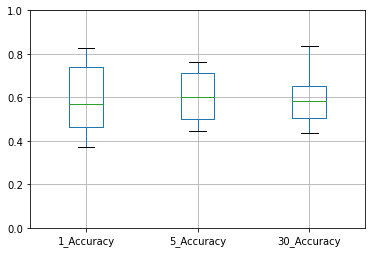

In [166]:

train_ratio = 0.8
accuracy = []
for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])
plt.ylim([0,1])
accdf

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.02s/it]


(0.0, 1.0)

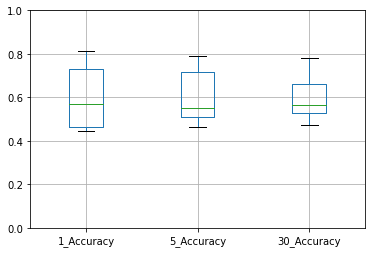

In [168]:
train_ratio = 0.8
accuracy = []
for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimGlove,train_ratio=train_ratio,train_rep = 100))
accdf = pd.DataFrame(accuracy)
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])
plt.ylim([0,1])


In [170]:
#finetuned bert
train_ratio = 0.8
accuracy = []
for idx in tqdm(range(len(raterids[:10]))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimBert,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.06s/it]


,UserID,1_Accuracy,1_Percision,1_Recall,5_Accuracy,5_Percision,5_Recall,30_Accuracy,30_Percision,30_Recall
0,32efff21538c13dd3f8d679dfb66fda0,0.585714,0.440000,0.566667,0.700000,0.643333,0.633333,0.657143,0.565000,0.648333
1,68eff82422ee0ce341e2b8b635bad447,0.627778,0.446905,0.302341,0.744444,0.585238,0.629643,0.644444,0.513359,0.577208
2,e154f85dba016fc4d1d07c62061c87a0,0.633333,0.300000,0.091667,0.800000,0.800000,0.491667,0.711111,0.550000,0.308333
3,2b28aec060b0c3e64e9237c1d757388f,0.800000,0.100000,0.050000,0.707143,0.250000,0.086667,0.685714,0.601667,0.307857
4,531b3014dafd0c2318b9d96e3a70290e,0.590909,0.593452,0.622381,0.700000,0.581984,0.841667,0.718182,0.759643,0.738373
5,7a9e974b437f3b16cbcd7798d92f2b2b,0.777778,0.000000,0.000000,0.722222,0.241667,0.145000,0.711111,0.441667,0.332857
6,269139e2ecc370ba50e750fe0b92fd26,0.536364,0.573333,0.377619,0.636364,0.767857,0.514762,0.600000,0.508214,0.522143
7,e3ed5f7cf078d072db53d04aa2507b48,0.554545,0.665000,0.365476,0.645455,0.698333,0.487381,0.600000,0.608333,0.523333
8,1b0417e7f9370a665795348a1eaa74d2,0.411111,0.433333,0.218333,0.600000,0.660000,0.410000,0.533333,0.466667,0.375000
9,3844b655c892e04a56000c6b538a4c39,0.772727,0.000000,0.000000,0.809091,0.316667,0.236667,0.718182,0.423333,0.550000


(0.0, 1.0)

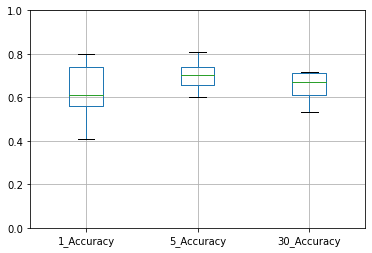

In [171]:
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])
plt.ylim([0,1])

  0%|                                                                                           | 0/84 [00:00<?, ?it/s]C:\Users\xthbo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\xthbo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [03:40<00:00,  2.63s/it]


1_Accuracy          0.743837
1_Percision         0.658430
1_Recall            0.606231
1_var_Accuracy      0.024795
1_var_Percision     0.021948
1_var_Recall        0.020208
5_Accuracy          0.809608
5_Percision         0.773027
5_Recall            0.746217
5_var_Accuracy      0.026987
5_var_Percision     0.025768
5_var_Recall        0.024874
30_Accuracy         0.817830
30_Percision        0.769485
30_Recall           0.763181
30_var_Accuracy     0.027261
30_var_Percision    0.025649
30_var_Recall       0.025439
dtype: float64

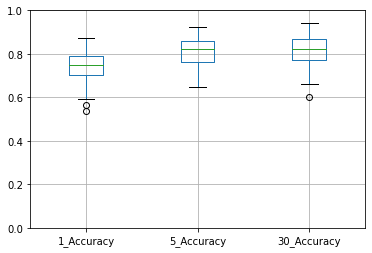

In [206]:
train_ratio = 0.8
accuracy = []
#userid = '2b4c74efa1d54d9b9b3642ea5243e63f'
for idx in tqdm(range(len(raterids))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimSurvey,survey = True,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])

plt.ylim([0,1])
accdf.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [06:26<00:00,  4.60s/it]


1_Accuracy          0.722708
1_Percision         0.672941
1_Recall            0.591435
1_var_Accuracy      0.024090
1_var_Percision     0.022431
1_var_Recall        0.019715
5_Accuracy          0.789818
5_Percision         0.753739
5_Recall            0.725869
5_var_Accuracy      0.026327
5_var_Percision     0.025125
5_var_Recall        0.024196
30_Accuracy         0.797685
30_Percision        0.754450
30_Recall           0.745660
30_var_Accuracy     0.026590
30_var_Percision    0.025148
30_var_Recall       0.024855
dtype: float64

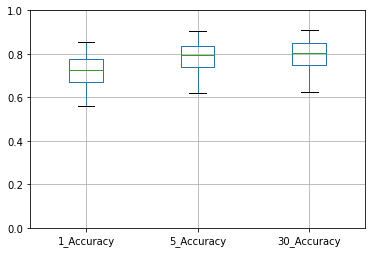

In [207]:
train_ratio = 0.5
accuracy = []
#userid = '2b4c74efa1d54d9b9b3642ea5243e63f'
for idx in tqdm(range(len(raterids))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimSurvey,survey = True,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])
plt.ylim([0,1])
accdf.to_csv('Result.valid/Survey.csv',index = False)
accdf.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:13<00:00,  1.15it/s]


1_Accuracy      0.741095
1_Percision     0.652475
1_Recall        0.603313
5_Accuracy      0.808171
5_Percision     0.762424
5_Recall        0.749026
30_Accuracy     0.811673
30_Percision    0.764651
30_Recall       0.754264
dtype: float64

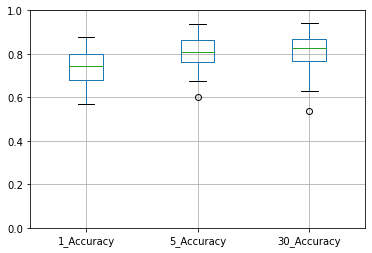

In [176]:
train_ratio = 0.8
accuracy = []
#userid = '2b4c74efa1d54d9b9b3642ea5243e63f'
for idx in tqdm(range(len(raterids))):
    userid = raterids[idx]
    accuracy.append(train_agent(userid,seeds,getDocSimSurvey,survey = True,train_ratio=train_ratio))
accdf = pd.DataFrame(accuracy)
accdf.boxplot(column=['1_Accuracy', '5_Accuracy','30_Accuracy'])
plt.ylim([0,1])
accdf.mean()

In [35]:
accdf = pd.DataFrame(accuracy)
#accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
#accdf.to_csv('user_response.csv',index = False)

#accdf.to_csv('baseline_lsa.csv',index = False)
#accdf.to_csv('baseline_glove.csv',index = False)
#accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
#accdf.to_csv('Fine_tuned_distil_roberta.csv')
#accdf.to_csv('Bert_baseline_sim.csv')
#accdf.to_csv('Fine_tuned_distil_roberta.model1.csv')

#nfile = './Result/LSA'
#nfile = './Result/Survey'
#nfile = './Result/Semantic_DistilBert'
#nfile = './Result/Finetune_DistilBert'

#nfile = './Result80_20/LSA'
#nfile = './Result80_20/Glove'

#nfile = './Result80_20/Survey'
#nfile = './Result80_20/Semantic_DistilBert'
#nfile = './Result80_20/Finetune_DistilBert.valid'
#accdf.to_csv(nfile+'.csv',index = False)
accdf.mean()

1_Accuracy      0.627197
1_Percision     0.512007
1_Recall        0.388475
5_Accuracy      0.695075
5_Percision     0.639583
5_Recall        0.534198
30_Accuracy     0.689550
30_Percision    0.612320
30_Recall       0.604460
dtype: float64

(0.0, 1.0)

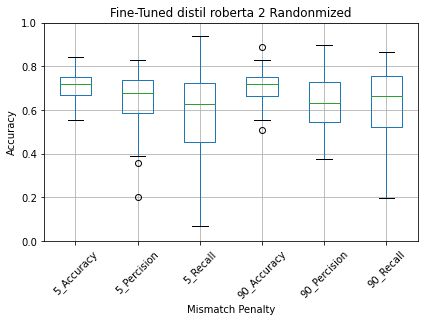

In [138]:


accdf = pd.read_csv('Fine_tuned_distil_roberta.model1.csv')
boxplot = accdf.boxplot(column=['5_Accuracy', '5_Percision', '5_Recall', 
                               # '30_Accuracy','30_Percision', '30_Recall', 
                               # '50_Accuracy', '50_Percision', '50_Recall',
                               '90_Accuracy', '90_Percision', '90_Recall'])
plt.title('Fine-Tuned distil roberta 2 Randonmized')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylim([0,1])

Text(0.5, 0, 'Recall')

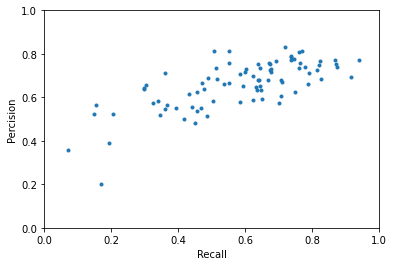

In [16]:
accdf = pd.read_csv('Fine_tuned_distil_roberta.model1.csv')
plt.plot(accdf['5_Recall'],accdf['5_Percision'],'.')
plt.ylim([0,1])
plt.xlim([0,1])
plt.ylabel('Percision')
plt.xlabel('Recall')

In [34]:
accruacy = []
for idx in tqdm(range(len(raterids))):
    userid = raterids[idx]
    accruacy.append(train_agent(userid,True))
accdf = pd.DataFrame(accruacy)
#accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
accdf.to_csv('user_response_randonmized.csv',index = False)

100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [1:21:06<00:00, 57.94s/it]


In [43]:
accdf = pd.DataFrame(accruacy)
accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})

accdf

,UserID,5,30,50,90,Counts
0,32efff21538c13dd3f8d679dfb66fda0,0.422222,0.416667,0.388889,0.394444,35
1,68eff82422ee0ce341e2b8b635bad447,0.686364,0.713636,0.743182,0.754545,87
2,e154f85dba016fc4d1d07c62061c87a0,0.759091,0.759091,0.740909,0.736364,43
3,2b28aec060b0c3e64e9237c1d757388f,0.800000,0.793939,0.824242,0.818182,66
4,531b3014dafd0c2318b9d96e3a70290e,0.765385,0.769231,0.769231,0.769231,52


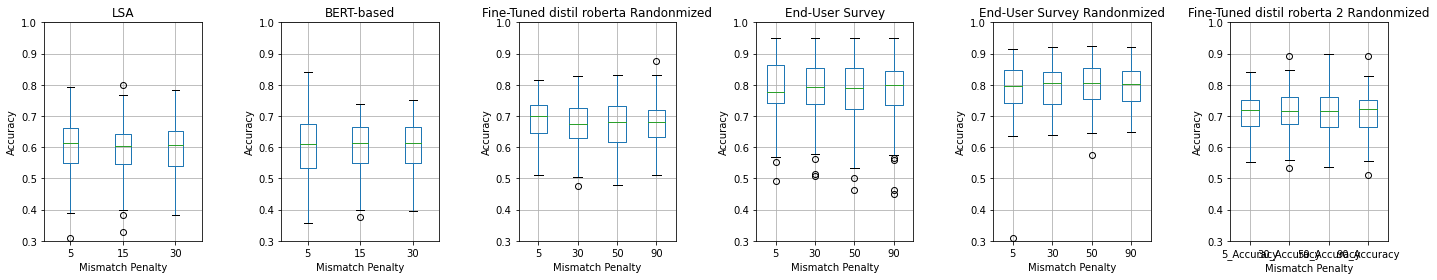

In [102]:
plt.figure(figsize = (20,4))
plt.subplot(1,6,1)
accdf = pd.read_csv('baseline_lsa.csv')
boxplot = accdf.boxplot(column=['5', '15','30'])
plt.ylim([0.3,1])
plt.title('LSA')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')

plt.subplot(1,6,2)
accdf = pd.read_csv('Bert_baseline_sim.csv')
boxplot = accdf.boxplot(column=['5', '15','30'])
plt.title('BERT-based')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])

plt.subplot(1,6,3)
accdf = pd.read_csv('Fine_tuned_distil_roberta.csv')
boxplot = accdf.boxplot(column=['5', '30','50','90'])
plt.title('Fine-Tuned distil roberta Randonmized')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.ylim([0.3,1])


plt.subplot(1,6,4)
accdf = pd.read_csv('user_response.csv')
boxplot = accdf.boxplot(column=['5', '30','50','90'])
plt.title('End-User Survey')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.ylim([0.3,1])

plt.subplot(1,6,5)
accdf = pd.read_csv('user_response_randonmized.csv')
boxplot = accdf.boxplot(column=['5', '30','50','90'])
plt.title('End-User Survey Randonmized')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.ylim([0.3,1])

plt.subplot(1,6,6)
accdf = pd.read_csv('Fine_tuned_distil_roberta.model1.csv')
boxplot = accdf.boxplot(column=['5_Accuracy', '30_Accuracy',
       '50_Accuracy',
       '90_Accuracy'])
plt.title('Fine-Tuned distil roberta 2 Randonmized')
plt.xlabel('Mismatch Penalty')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.ylim([0.3,1])


plt.savefig('summaryresult.latest.png')

(0.45, 1.0)

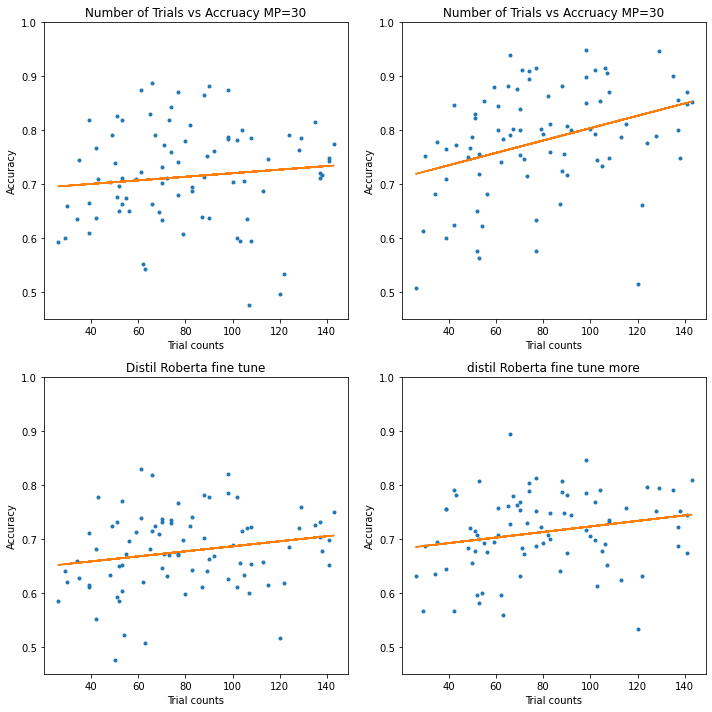

In [57]:

def Trial_acc(nfile,title):
    accdf = pd.read_csv(nfile)
#oder effect 
#accdf = pd.read_csv('user_response.csv')
#accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
    x,y = accdf['Counts'],accdf['30']
    #boxplot = accdf.boxplot(column=['5', '30','50','90'])
    plt.plot(x,y,'.')
    plt.xlabel('Trial counts')
    plt.ylabel('Accuracy')

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.tight_layout()
    plt.title(title)
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
accdf = pd.read_csv('Result/Survey.csv')
accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
x,y = accdf['Counts'],accdf['30_Accuracy']
plt.plot(x,y,'.')
plt.title('Number of Trials vs Accruacy MP=30')
plt.xlabel('Trial counts')
plt.ylabel('Accuracy')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.ylim([0.45,1])
plt.subplot(2,2,2)

#accdf = pd.read_csv('Fine_tuned_distil_roberta.csv')
#oder effect 
accdf = pd.read_csv('user_response.csv')
accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
x,y = accdf['Counts'],accdf['30']
plt.plot(x,y,'.')
plt.title('Number of Trials vs Accruacy MP=30')
plt.xlabel('Trial counts')
plt.ylabel('Accuracy')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.ylim([0.45,1])

plt.subplot(2,2,3)
Trial_acc('Fine_tuned_distil_roberta.csv','Distil Roberta fine tune')
plt.ylim([0.45,1])

plt.subplot(2,2,4)

accdf = pd.read_csv('Fine_tuned_distil_roberta.model1.csv')
accdf = pd.merge(accdf,counts, left_on = 'UserID',right_on ='RaterID').rename(columns = {'index':'Counts'})
x,y = accdf['Counts'],accdf['30_Accuracy']
plt.plot(x,y,'.')
plt.title('distil Roberta fine tune more')
plt.xlabel('Trial counts')
plt.ylabel('Accuracy')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.ylim([0.45,1])
#Trial_acc('Fine_tuned_distil_roberta.model1.csv','Number of Trials vs Accruacy MP=30')


In [170]:
accdf = pd.read_csv('baseline_lsa.csv')
#boxplot = accdf.boxplot(column=['5', '30','50','90'])
accdf.mean()

5     0.597921
15    0.589845
30    0.591462
dtype: float64

In [172]:
accdf = pd.read_csv('Bert_baseline_sim.csv')
#boxplot = accdf.boxplot(column=['5', '30','50','90'])
accdf.describe()

,Unnamed: 0,5,15,30
count,84.000000,84.000000,84.000000,84.000000
mean,41.500000,0.597659,0.602781,0.602225
std,24.392622,0.097197,0.085292,0.086049
min,0.000000,0.356250,0.378125,0.394444
25%,20.750000,0.534295,0.550238,0.549819
50%,41.500000,0.611111,0.614722,0.612897
75%,62.250000,0.673295,0.664701,0.664228
max,83.000000,0.840816,0.739394,0.752381


In [ ]:
#What makes end-user decide whether reply to the email?


#Can we use the similarity between End-User response to model language similiarity? 
# individual differences are very large!


In [7]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
fpr

tpr

thresholds

array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])

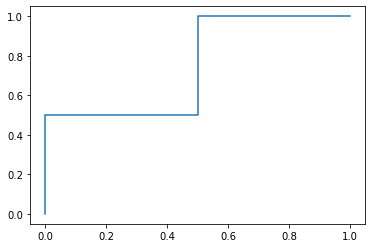

In [8]:
plt.plot(fpr,tpr)

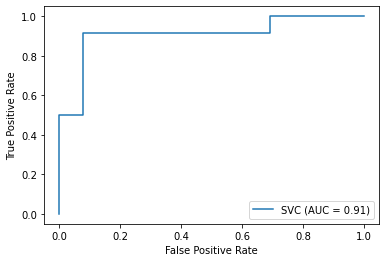

In [11]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
X, y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, random_state=0)
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)

metrics.plot_roc_curve(clf, X_test, y_test)  
plt.show()     